# Projeto: Análise de Anomalias em Série Temporal

BIMASTER - Trabalho de final de curso

Nome: Alex Marques Campos

Etapa 02.A: Detecção de anomalias via métodos estatísticos

O objetivo deste notebook é carregar os dados das séries históricas de interesse e observar se é possível utilizar métodos estatísticos para realizar a detecção de anomalias nos dados. Para isso, focaremos no uso do __z-score modificado__, mas também utilizaremos o método __CUMSUM__, de somas cumulativas.

O primeiro passo é carregar as bibliotecas necessárias ao processamento e os dados propriamente ditos, que estão armazenados nos arquivos CSV (_comma separated values_) armazenados no subdiretório './__dados__/'.

## Configuração do ambiente de execução

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

In [ ]:
NOME_DIRETORIO_DADOS = 'dados'
NOME_ARQUIVO_SERIE_IBCBR = 'serie_ibcbr.csv'
NOME_ARQUIVO_SERIE_IBCBR_RESIDUO = 'serie_ibcbr_residuo.csv'
NOME_ARQUIVO_SERIE_IBCBR_DIFERENCAS = 'serie_ibcbr_diferencas.csv'
NOME_ARQUIVO_SERIE_IBCBR_DIFERENCAS_RESIDUO = 'serie_ibcbr_diferencas_residuo.csv'

In [ ]:
print(f'pandas == {pd.__version__}')
print(f'matplotlib == {matplotlib.__version__}')

pandas == 1.3.5
matplotlib == 3.2.2


In [ ]:
# ajustamos o formato de apresentação padrão dos gráficos
sns.set_theme(style="white", palette="pastel")

In [ ]:
# habilitamos a visualização especial de dataframes disponível no
# Google Colaboratory, para facilitar a exploração dos dados.
from google.colab import data_table
data_table.enable_dataframe_formatter()

## Carga dos dados

Lembre-se de criar uma pasta chamada '/content/dados' no Google Colaboratory e enviar os arquivos '.csv' para essa pasta.

In [ ]:
path_dir_dados = Path('.') / NOME_DIRETORIO_DADOS

path_arq_ibcbr     = path_dir_dados / NOME_ARQUIVO_SERIE_IBCBR
path_arq_ibcbr_res = path_dir_dados / NOME_ARQUIVO_SERIE_IBCBR_RESIDUO
path_arq_dif       = path_dir_dados / NOME_ARQUIVO_SERIE_IBCBR_DIFERENCAS
path_arq_dif_res   = path_dir_dados / NOME_ARQUIVO_SERIE_IBCBR_DIFERENCAS_RESIDUO

In [ ]:
def carregar_csv(path_csv:Path) -> pd.DataFrame:
  """
  Carrega os dados de um arquivo CSV em um dataframe de
  forma padronizada no escopo do projeto.
  path_csv : objeto Path que aponta para o arquivo.
  """
  if (path_csv is None) or (not path_csv.is_file()):
    raise ValueError("The given path object doesn't point to a valid csv file.")

  return pd.read_csv(path_csv,
                   sep=',',
                   parse_dates=True,
                   infer_datetime_format=True,
                   index_col=0,
                   decimal='.',
                   encoding='utf8')

In [ ]:
# carregamos os arquivos de dados em dataframes, para iniciar a análise
df_ibcbr     = carregar_csv(path_arq_ibcbr)
df_ibcbr_res = carregar_csv(path_arq_ibcbr_res)
df_dif       = carregar_csv(path_arq_dif)
df_dif_res   = carregar_csv(path_arq_dif)

In [ ]:
def verificar_propriedades(id:int, nome:str, dataframe:pd.DataFrame) -> None:
  """
  Imprime propriedades do dataframe nomeado para inspeção visual dos dados.
  id: inteiro que identifica o dataframe.
  nome: nome do dataframe
  dataframe: objeto do dataframe
  """
  print(f'[{id:03d}] Dataframe: {nome}')
  print('-' * 5)
  print(f'Shape: {dataframe.shape}')
  print('-' * 5)
  print(dataframe.head(4))
  print('')

In [ ]:
# verificamos se os dataframes foram carregados corretamente.
series = {
  'IBC-BR': df_ibcbr,
  'IBC-BR (resíduo)': df_ibcbr_res,
  'Diferenças': df_dif,
  'Diferenças (resíduo)': df_dif_res
}

for idx,serie in enumerate(series.items()):
  verificar_propriedades(idx+1, serie[0], serie[1])

[001] Dataframe: IBC-BR
-----
Shape: (236, 1)
-----
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19

[002] Dataframe: IBC-BR (resíduo)
-----
Shape: (224, 1)
-----
               valor
data                
2003-07-01  0.988355
2003-08-01  0.972326
2003-09-01  1.007602
2003-10-01  1.009311

[003] Dataframe: Diferenças
-----
Shape: (235, 1)
-----
            valor
data             
2003-02-01   2.52
2003-03-01   4.74
2003-04-01  -1.22
2003-05-01  -1.89

[004] Dataframe: Diferenças (resíduo)
-----
Shape: (235, 1)
-----
            valor
data             
2003-02-01   2.52
2003-03-01   4.74
2003-04-01  -1.22
2003-05-01  -1.89



Neste ponto, temos todos os dados carregados em DataFrames pandas e prontos para análise.

## Análise estatística

### z-score modificado (série de resíduos)

Nossa primeira abordagem será a análise do z-score modificado das séries estacionárias, para tentar encontrar anomalias. O uso do z-score modificado no lugar do z-score padrão decorre (1) da premissa de que existem _outliars_ nos dados e (2) no fato que _outliars_ modificam a média e o desvio padrão, o que influencia o cálculo do z-score padrão. O z-score modificado usa a mediana e o desvio absoluto mediano (MAD), que são mais resilientes à _outliars_ nos dados.

Começamos definindo as funções auxiliares para obter as estatísticas desejadas.

In [ ]:
def calcular_mad(dataframe:pd.DataFrame) -> float:
  """
  Calcula o desvio absoluto mediano (sigla MAD, do inglês 'median
  absolute deviation') dos dados de um dataframe.
  """
  mediana = np.median(dataframe)
  mad = np.median(np.abs(dataframe - mediana))

  return mad

def calcular_zscore_mod(x:float, mediana:float, mad:float, k:float=1.4826) -> float:
  """
  Calcula o z-score modificado de um elemento x, com base
  no elemento, em uma mediana e no MAD.
  x : elemento a considerar.
  mediana : mediana a considerar.
  MAD : desvio absoluto mediano a considerar.
  k : fator de correção (veja https://en.wikipedia.org/wiki/Median_absolute_deviation)
  retorna o z-score modificado calculado para o elemento.
  """
  assert (k > 0)
  assert (mad > 0)

  return (x - mediana) / (k * mad)

def calcular_zscore_mod(dataframe:pd.DataFrame, k:float=1.4826) -> pd.DataFrame:
  """
  Calcula o z-score modificado de todos os elementos de um
  dataframe. Não modifica o dataframe recebido.
  dataframe : dataframe para o qual se deseja calcular o z-score.
  k : fator de correção (veja https://en.wikipedia.org/wiki/Median_absolute_deviation)
  Retorna um objeto pandas.DataFrame com os valores dos z-scores
  dos elementos.
  """
  assert (k > 0)
  mediana = np.median(dataframe)
  mad = calcular_mad(dataframe)
  assert (mad > 0)
  return (dataframe - mediana) / (k * mad)

Depois, começamos a análise estatística do resíduo da série IBC-BR.

In [ ]:
# imprimimos estatísticas do conjunto de dados só para auxiliar na análise
df_ibcbr_res.describe()

,valor
count,224.000000
mean,0.999796
std,0.017775
min,0.893994
25%,0.991451
50%,1.000503
75%,1.009582
max,1.052196


In [ ]:
print(f'Mediana do resíduo do IBC-BR: {np.median(df_ibcbr_res)}')

Mediana do resíduo do IBC-BR: 1.0005033876381089


In [ ]:
ibcbr_res_mad = calcular_mad(df_ibcbr_res)
print(f'MAD do resíduo do IBC-BR = {ibcbr_res_mad}.')

MAD do resíduo do IBC-BR = 0.009062644702768241.


In [ ]:
def adicionar_zscore_modificado(df:pd.DataFrame) -> pd.DataFrame:
  df_zscore = df.copy()
  df_zscore['z-score mod'] = calcular_zscore_mod(df_zscore)
  return df_zscore

In [ ]:
# criamos uma cópia do dataframe e calculamos o z-score modificado
# de suas entradas
df_ibcbr_res_zscore = adicionar_zscore_modificado(df_ibcbr_res)
display(df_ibcbr_res_zscore.head())

,valor,z-score mod
data,,
2003-07-01,0.988355,-0.904159
2003-08-01,0.972326,-2.097129
2003-09-01,1.007602,0.528325
2003-10-01,1.009311,0.655498
2003-11-01,0.992433,-0.600664


In [ ]:
def filtrar_anomalias(df_zscore:pd.DataFrame,
                      limiar_anomalia:float=2.5) -> pd.DataFrame:
  '''
  Função auxiliar para filtrar as entradas de um DataFrame, que contenha
  uma coluna chamada "z-score mod" que represente o z-score modificado.
  A função retorna as entradas que estão acima de "limiar_anomalia" e
  abaixo de "-limiar_anomalia".
  df_zscore: Pandas DataFrame a ser filtrado (precisa conter uma coluna chamada
             "z-score mod").
  limiar_anomalia: limiar de z-score modificado que divide os valores normais
                  das anomalias.
  '''
  assert(limiar_anomalia > 0)
  assert('z-score mod' in df_zscore.columns)

  filtro_acima_lim_sup = df_zscore['z-score mod'] > limiar_anomalia
  filtro_abaixo_lim_inf = df_zscore['z-score mod'] < -limiar_anomalia

  return df_zscore[ filtro_acima_lim_sup | filtro_abaixo_lim_inf ]

In [ ]:
# depois filtramos os dados em busca de anomalias,
# assumindo que qualquer coisa acima de 2.5 unidades
# de MAD é uma anomalia.

df_res_anomalias = filtrar_anomalias(df_ibcbr_res_zscore)

In [ ]:
display(df_res_anomalias)

,valor,z-score mod
data,,
2008-07-01,1.034370,2.520569
2008-09-01,1.038398,2.820339
2008-12-01,0.955111,-3.378379
2009-01-01,0.959341,-3.063555
2009-02-01,0.960103,-3.006779
2020-01-01,1.046810,3.446424
2020-02-01,1.052196,3.847261
2020-04-01,0.893994,-7.927020
2020-05-01,0.904317,-7.158683


O processo parece ter detectado anomalias em 2008 e 2009 (potenciais efeitos da crise do mercado financeiro mundial de 2008) e de dezembro de 2019 até junho de 2020 (potenciais efeitos da pandemia de COVID-19).

Faremos uma análise visual do gráfico do IBC-BR, marcando as anomalias identificadas no processo.

In [ ]:
def configurar_ticks_anuais(ax):
  '''
  Procedimento auxiliar para configurar a exibição do eixo x
  de um gráfico do matplotlib para dados de séries temporais
  para os quais só sejam marcados os valores ano a ano.
  '''
  ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
  ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

In [ ]:
def desenhar_serie_com_anomalias(df:pd.DataFrame,
                                 indice_anomalias:pd.core.indexes.datetimes.DatetimeIndex,
                                 nome_serie:str='IBC-BR',
                                 df_cumsum:pd.DataFrame=None) -> None:
  fig = plt.figure(figsize=(16,5))

  plt.plot(df['valor'], 'b', label=f'Índice {nome_serie}')

  for e in indice_anomalias:
    plt.axvline(x=e, color='r', linestyle=':')

  if not df_cumsum is None:
    plt.scatter(x=df_cumsum.index,
                y=df_cumsum['high_cumsum'],
                s=0.8,
                color='orange',
                label='CUMSUM (High)')

  plt.legend(loc='best')
  plt.ylabel(nome_serie)
  plt.xlabel('Tempo')

  # ajustamos o eixo x da figura para exibir ticks a cada ano
  configurar_ticks_anuais(fig.axes[0])

  plt.show()

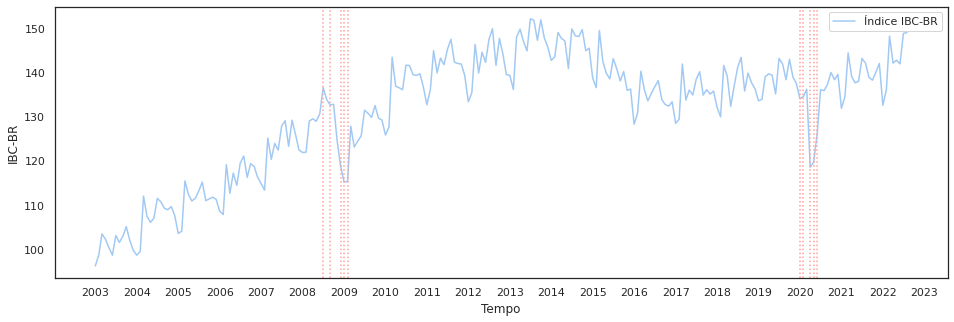

In [ ]:
desenhar_serie_com_anomalias(df_ibcbr, df_res_anomalias.index)

### z-score modificado (série de diferenças)

Analisaremos agora a série de diferenças, para verificar se é possível identificar as mesmas anomalias encontradas via a série de resíduos utilizando a série de diferenças.

In [ ]:
df_dif_zscore = adicionar_zscore_modificado(df_dif)

In [ ]:
display(df_dif_zscore.head())

,valor,z-score mod
data,,
2003-02-01,2.52,0.781859
2003-03-01,4.74,1.393030
2003-04-01,-1.22,-0.247772
2003-05-01,-1.89,-0.432225
2003-06-01,-1.72,-0.385423


In [ ]:
df_dif_anomalias = filtrar_anomalias(df_dif_zscore)

In [ ]:
display(df_dif_anomalias)

,valor,z-score mod
data,,
2004-03-01,12.53,3.537635
2005-03-01,11.42,3.232050
2006-03-01,11.29,3.196260
2007-03-01,11.78,3.331158
2009-03-01,12.55,3.543141
2010-03-01,15.83,4.446133
2012-03-01,11.00,3.116423
2013-03-01,11.87,3.355936
2014-07-01,8.97,2.557559


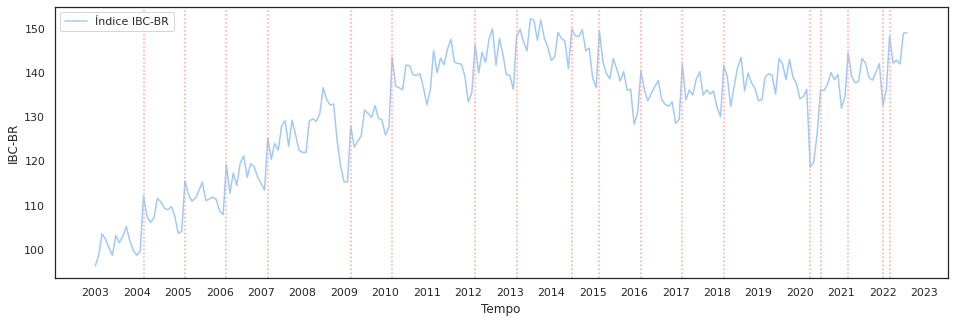

In [ ]:
desenhar_serie_com_anomalias(df_ibcbr, df_dif_anomalias.index)

Vamos utilizar um limiar maior, para ver se os dados se aproximam das anomalias detectadas na série de resíduos.

,valor,z-score mod
data,,
2004-03-01,12.53,3.537635
2009-03-01,12.55,3.543141
2010-03-01,15.83,4.446133
2015-03-01,12.93,3.647756
2017-03-01,12.51,3.532129
2020-04-01,-17.67,-4.776496


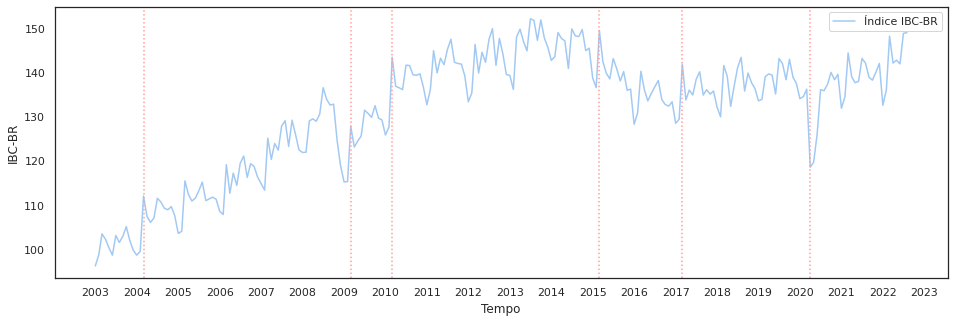

In [ ]:
df_dif_anomalias_3_5 = filtrar_anomalias(df_dif_zscore, limiar_anomalia=3.5)
display(df_dif_anomalias_3_5)
desenhar_serie_com_anomalias(df_ibcbr, df_dif_anomalias_3_5.index)

As anomalias encontradas analisando apenas a série de diferenças são muito diferentes das anomalias que entendemos existirem nos dados. Verificamos que os valores das diferenças, apesar de serem uma série estacionária, ainda carregam em si a modulação da tendência e da sazonalidade e isso influencia grandemente a série. Essa abordagem é bastante prática para detectar grandes variações entre valores consecutivos, mas não é boa para detectar as anomalias no escopo semântico da série (momentos em que a _série_ se comportou de maneira inesperada com relação à sua proposta).

### CUMSUM (série de resíduos)

Faremos agora o cálculo do CUMSUM, como apresentado no arquivo 'deteçãodeanomaliasemseries.ipynb' do curso BIMASTER, para verificar o resultado da detecção de anomalias através desse método.

In [ ]:
def calcular_cumsum(df:pd.DataFrame, unidades_limiar:float=2.5):
  soma_alta = 0.0
  soma_baixa = 0.0

  cumsum_superior = []
  cumsum_inferior = []

  # temos que selecionar a coluna para obter um valor real
  # usamos o iloc só para o código ficar mais resiliente
  # ao nome da primeira coluna
  media = df.iloc[:,0].mean()
  desvio_padrao = df.iloc[:,0].std()

  limiar = unidades_limiar * desvio_padrao

  dict_anomalias = {}

  for idx,valor in zip(df.index, df.iloc[:,0]):
    soma_alta = max(0.0, valor - media - desvio_padrao)
    soma_baixa = min(0.0, valor + media + desvio_padrao)
    
    cumsum_superior.append(soma_alta)
    cumsum_inferior.append(soma_baixa)

    if soma_alta > limiar or soma_baixa < -limiar:
      dict_anomalias[idx] = valor

  # montamos dataframes para retornar ao solicitante
  df_cumsum = pd.DataFrame(index=df.index, 
                           data={'high_cumsum': cumsum_superior,
                               'low_cumsum': cumsum_inferior})
  
  df_anomalias = pd.DataFrame(index=dict_anomalias.keys(),
                              data=dict_anomalias.values(),
                              columns=[df.columns[0]]) # usamos o mesmo nome da coluna original

  return df_cumsum, df_anomalias

In [ ]:
df_res_cumsum, df_res_cumsum_anomalias = calcular_cumsum(df_ibcbr_res, 0.8)

In [ ]:
display(df_res_cumsum_anomalias)

,valor
2008-07-01,1.034370
2008-09-01,1.038398
2019-12-01,1.033942
2020-01-01,1.046810
2020-02-01,1.052196


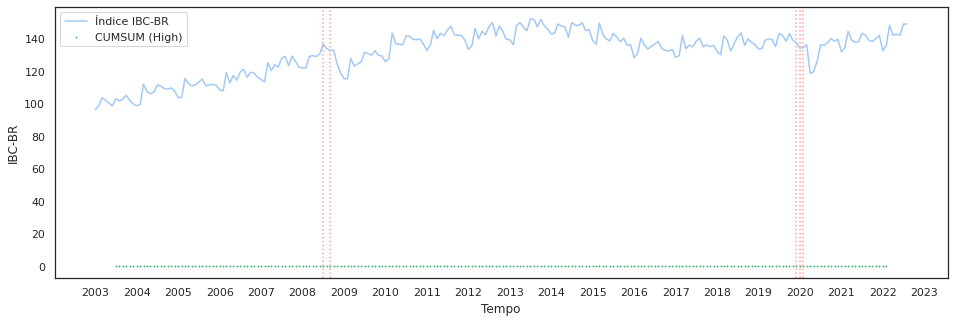

In [ ]:
desenhar_serie_com_anomalias(df=df_ibcbr, 
                             indice_anomalias=df_res_cumsum_anomalias.index,
                             df_cumsum=df_res_cumsum)